# Emotion Detection

### Imports

In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim

### Configs

In [2]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

### 1. Load dos Datasets

##### 1.1. Carregando arquivos em dataframes

In [3]:
df_train = pd.read_csv('ptbr_train.csv')
df_test = pd.read_csv('ptbr_test.csv')

##### 1.2. Pequena análise exploratória

Aqui buscamos apenas ver o formato dos dados e se existe algum faltante.

1.2.1. df_train

In [4]:
df_train.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,ptbr_train_track_a_00001,Moça eu fiz uma análise com o Tinder uma vez e TB sou programador. Perdi uma mês analisando toda a dinâmica disso e posso te responder isso só não posso falar o que fiz aqui por que posso ser linc...,0,0,0,0,0,0
1,ptbr_train_track_a_00002,"eles sempre mostram a míseria, em como tudo era um nojo. a comparação deles de um esgoto e o século passado é a mesma.",1,1,0,0,0,0
2,ptbr_train_track_a_00003,"eu nunca quis tanto algo como quero você. jamais passou pela minha cabeça necessitar qualquer coisa, como necessito seus beijos. percebe o que fez comigo? me tornei tudo que eu imaginava que nunca...",0,0,0,1,1,0
3,ptbr_train_track_a_00004,esperando aqui o stf vim me emparedar do eu expressar o direito de liberdade!,1,0,0,0,0,0
4,ptbr_train_track_a_00005,"e no final o PS vai pagar o pato, ja é o 4° treinador depois do JJ, mas a torcida ainda não percebe isso.",1,0,0,0,0,0


In [5]:
df_train.shape


(2226, 8)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2226 non-null   object
 1   text      2226 non-null   object
 2   anger     2226 non-null   int64 
 3   disgust   2226 non-null   int64 
 4   fear      2226 non-null   int64 
 5   joy       2226 non-null   int64 
 6   sadness   2226 non-null   int64 
 7   surprise  2226 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 139.3+ KB


In [7]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

print("----- valores existentes em cada coluna -----")

for emotion in emotions:
    unique_values = df_train[emotion].unique()
    print(f"{emotion}: {sorted(unique_values)}")

----- valores existentes em cada coluna -----
anger: [0, 1]
disgust: [0, 1]
fear: [0, 1]
joy: [0, 1]
sadness: [0, 1]
surprise: [0, 1]


1.2.2. df_test

In [8]:
df_test.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,ptbr_test_track_a_00001,"me recuso a sair de casa nesse frio do caralho, só quero minha cama",1,0,0,0,0,0
1,ptbr_test_track_a_00002,tenho desde camisola nova até vestido de festa uhul,0,0,0,1,0,0
2,ptbr_test_track_a_00003,"minha playlist de descobertas veio com trap, rap e quatro kpops masculinos, eu deixei meu amigo usar por um tempinho e a porra da apple ainda não começou a colocar só girlgroup de novo ...",1,0,0,0,0,0
3,ptbr_test_track_a_00004,"Então, acho que ele gosta de homem e nem sabe ainda. Homem com barba.",0,0,0,0,0,0
4,ptbr_test_track_a_00005,"Parabéns, Prof. Fernando. Parabéns às educadoras e aos educadores do Brasil, incansáveis no ofício de ensinar.",0,0,0,1,0,0


In [9]:
df_test.shape

(2226, 8)

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2226 non-null   object
 1   text      2226 non-null   object
 2   anger     2226 non-null   int64 
 3   disgust   2226 non-null   int64 
 4   fear      2226 non-null   int64 
 5   joy       2226 non-null   int64 
 6   sadness   2226 non-null   int64 
 7   surprise  2226 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 139.3+ KB


In [11]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

print("----- valores existentes em cada coluna -----")

for emotion in emotions:
    unique_values = df_test[emotion].unique()
    print(f"{emotion}: {sorted(unique_values)}")

----- valores existentes em cada coluna -----
anger: [0, 1]
disgust: [0, 1]
fear: [0, 1]
joy: [0, 1]
sadness: [0, 1]
surprise: [0, 1]


fazendo a união dos dois datasets para simplificar o pré processamento.

mais na frente, para treinar o modelo, será possível escolher a divisão entre dataset de treino e teste.

In [12]:
df = pd.concat([df_train, df_test], ignore_index=True)

print(f"Dataset combinado: {df.shape}")
print(f"Original train: {df_train.shape}")
print(f"Original test: {df_test.shape}")
df.head()

Dataset combinado: (4452, 8)
Original train: (2226, 8)
Original test: (2226, 8)


,id,text,anger,disgust,fear,joy,sadness,surprise
0,ptbr_train_track_a_00001,Moça eu fiz uma análise com o Tinder uma vez e TB sou programador. Perdi uma mês analisando toda a dinâmica disso e posso te responder isso só não posso falar o que fiz aqui por que posso ser linc...,0,0,0,0,0,0
1,ptbr_train_track_a_00002,"eles sempre mostram a míseria, em como tudo era um nojo. a comparação deles de um esgoto e o século passado é a mesma.",1,1,0,0,0,0
2,ptbr_train_track_a_00003,"eu nunca quis tanto algo como quero você. jamais passou pela minha cabeça necessitar qualquer coisa, como necessito seus beijos. percebe o que fez comigo? me tornei tudo que eu imaginava que nunca...",0,0,0,1,1,0
3,ptbr_train_track_a_00004,esperando aqui o stf vim me emparedar do eu expressar o direito de liberdade!,1,0,0,0,0,0
4,ptbr_train_track_a_00005,"e no final o PS vai pagar o pato, ja é o 4° treinador depois do JJ, mas a torcida ainda não percebe isso.",1,0,0,0,0,0


### 2. Limpeza dos Textos

Processo de limpeza utilizado no _sentiment.py_

In [13]:
# Punctuation list
punctuations = re.escape('!"#%\'()*+,./:;<=>?@[\\]^_`{|}~')

# ##### #
# Regex #
# ##### #
re_remove_brackets = re.compile(r'\{.*\}')
re_remove_html = re.compile(r'<(\/|\\)?.+?>', re.UNICODE)
re_transform_numbers = re.compile(r'\d', re.UNICODE)
re_transform_emails = re.compile(r'[^\s]+@[^\s]+', re.UNICODE)
re_transform_url = re.compile(r'(http|https)://[^\s]+', re.UNICODE)
re_transform_username = re.compile(r'@[^\s]+', re.UNICODE)
# Different quotes are used.
re_quotes_1 = re.compile(r"(?u)(^|\W)[‘’′`']", re.UNICODE)
re_quotes_2 = re.compile(r"(?u)[‘’`′'](\W|$)", re.UNICODE)
re_quotes_3 = re.compile(r'(?u)[‘’`′“”]', re.UNICODE)
re_dots = re.compile(r'(?<!\.)\.\.(?!\.)', re.UNICODE)
re_punctuation = re.compile(r'([,";:]){2},', re.UNICODE)
re_hiphen = re.compile(r' -(?=[^\W\d_])', re.UNICODE)
re_tree_dots = re.compile(u'…', re.UNICODE)
# Differents punctuation patterns are used.
re_punkts = re.compile(r'(\w+)([%s])([ %s])' %
                       (punctuations, punctuations), re.UNICODE)
re_punkts_b = re.compile(r'([ %s])([%s])(\w+)' %
                         (punctuations, punctuations), re.UNICODE)
re_punkts_c = re.compile(r'(\w+)([%s])$' % (punctuations), re.UNICODE)
re_changehyphen = re.compile(u'–')
re_doublequotes_1 = re.compile(r'(\"\")')
re_doublequotes_2 = re.compile(r'(\'\')')
re_trim = re.compile(r' +', re.UNICODE)

In [14]:
def clean_text(text):
    """Apply all regex above to a given string."""
    text = text.lower()
    text = text.replace('\xa0', ' ')
    text = text.replace('#', ' ')
    text = re_tree_dots.sub('...', text)
    text = re.sub('\.\.\.', '', text)
    text = re_remove_brackets.sub('', text)
    text = re_changehyphen.sub('-', text)
    text = re_remove_html.sub(' ', text)
    text = re_transform_numbers.sub('0', text)
    text = re_transform_url.sub('URL', text)
    text = re_transform_username.sub('USERNAME', text)
    text = re_transform_emails.sub('EMAIL', text)
    text = re_quotes_1.sub(r'\1"', text)
    text = re_quotes_2.sub(r'"\1', text)
    text = re_quotes_3.sub('"', text)
    text = re.sub('"', '', text)
    text = re_dots.sub('.', text)
    text = re_punctuation.sub(r'\1', text)
    text = re_hiphen.sub(' - ', text)
    text = re_punkts.sub(r'\1 \2 \3', text)
    text = re_punkts_b.sub(r'\1 \2 \3', text)
    text = re_punkts_c.sub(r'\1 \2', text)
    text = re_doublequotes_1.sub('\"', text)
    text = re_doublequotes_2.sub('\'', text)
    text = re_trim.sub(' ', text)
    return text.strip()

In [15]:
df['clean_text'] = np.vectorize(clean_text)(df['text'])

df.head()

,id,text,anger,disgust,fear,joy,sadness,surprise,clean_text
0,ptbr_train_track_a_00001,Moça eu fiz uma análise com o Tinder uma vez e TB sou programador. Perdi uma mês analisando toda a dinâmica disso e posso te responder isso só não posso falar o que fiz aqui por que posso ser linc...,0,0,0,0,0,0,moça eu fiz uma análise com o tinder uma vez e tb sou programador . perdi uma mês analisando toda a dinâmica disso e posso te responder isso só não posso falar o que fiz aqui por que posso ser lin...
1,ptbr_train_track_a_00002,"eles sempre mostram a míseria, em como tudo era um nojo. a comparação deles de um esgoto e o século passado é a mesma.",1,1,0,0,0,0,"eles sempre mostram a míseria , em como tudo era um nojo . a comparação deles de um esgoto e o século passado é a mesma ."
2,ptbr_train_track_a_00003,"eu nunca quis tanto algo como quero você. jamais passou pela minha cabeça necessitar qualquer coisa, como necessito seus beijos. percebe o que fez comigo? me tornei tudo que eu imaginava que nunca...",0,0,0,1,1,0,"eu nunca quis tanto algo como quero você . jamais passou pela minha cabeça necessitar qualquer coisa , como necessito seus beijos . percebe o que fez comigo ? me tornei tudo que eu imaginava que n..."
3,ptbr_train_track_a_00004,esperando aqui o stf vim me emparedar do eu expressar o direito de liberdade!,1,0,0,0,0,0,esperando aqui o stf vim me emparedar do eu expressar o direito de liberdade !
4,ptbr_train_track_a_00005,"e no final o PS vai pagar o pato, ja é o 4° treinador depois do JJ, mas a torcida ainda não percebe isso.",1,0,0,0,0,0,"e no final o ps vai pagar o pato , ja é o 0° treinador depois do jj , mas a torcida ainda não percebe isso ."


In [16]:
from emoji import demojize
df.clean_text = df.clean_text.apply(lambda x: demojize(x, language='pt'))

# remover palavras com menos que 3 letras
df.clean_text = df.clean_text.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

clean_df = df[['clean_text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']]

clean_df.head()

,clean_text,anger,disgust,fear,joy,sadness,surprise
0,moça análise tinder programador perdi analisando toda dinâmica disso posso responder isso posso falar aqui posso linchado maluco nada geral funciona desvio comportamento nesses apps quiser detalhe...,0,0,0,0,0,0
1,eles sempre mostram míseria como tudo nojo comparação deles esgoto século passado mesma,1,1,0,0,0,0
2,nunca quis tanto algo como quero você jamais passou pela minha cabeça necessitar qualquer coisa como necessito seus beijos percebe comigo tornei tudo imaginava nunca seria você virou avesso perceb...,0,0,0,1,1,0
3,esperando aqui emparedar expressar direito liberdade,1,0,0,0,0,0
4,final pagar pato treinador depois torcida ainda percebe isso,1,0,0,0,0,0


### 3. Tokenização

Como o texto já está bem limpo, utilizaremos apenas um split para tokenizar as frases.

In [17]:
def tokenizar(text):
    return text.split()

clean_df['tokenized_text'] = clean_df.loc[:, 'clean_text'].apply(tokenizar)

clean_df.head(10)

,clean_text,anger,disgust,fear,joy,sadness,surprise,tokenized_text
0,moça análise tinder programador perdi analisando toda dinâmica disso posso responder isso posso falar aqui posso linchado maluco nada geral funciona desvio comportamento nesses apps quiser detalhe...,0,0,0,0,0,0,"[moça, análise, tinder, programador, perdi, analisando, toda, dinâmica, disso, posso, responder, isso, posso, falar, aqui, posso, linchado, maluco, nada, geral, funciona, desvio, comportamento, ne..."
1,eles sempre mostram míseria como tudo nojo comparação deles esgoto século passado mesma,1,1,0,0,0,0,"[eles, sempre, mostram, míseria, como, tudo, nojo, comparação, deles, esgoto, século, passado, mesma]"
2,nunca quis tanto algo como quero você jamais passou pela minha cabeça necessitar qualquer coisa como necessito seus beijos percebe comigo tornei tudo imaginava nunca seria você virou avesso perceb...,0,0,0,1,1,0,"[nunca, quis, tanto, algo, como, quero, você, jamais, passou, pela, minha, cabeça, necessitar, qualquer, coisa, como, necessito, seus, beijos, percebe, comigo, tornei, tudo, imaginava, nunca, seri..."
3,esperando aqui emparedar expressar direito liberdade,1,0,0,0,0,0,"[esperando, aqui, emparedar, expressar, direito, liberdade]"
4,final pagar pato treinador depois torcida ainda percebe isso,1,0,0,0,0,0,"[final, pagar, pato, treinador, depois, torcida, ainda, percebe, isso]"
5,simm muito famoso aqui mais fora tanto acho aparição dele série certo série solo,0,0,0,0,0,0,"[simm, muito, famoso, aqui, mais, fora, tanto, acho, aparição, dele, série, certo, série, solo]"
6,será esses caras tentar fazer moeda euro sula piada isso fracassar seria algo interessante desse certo querer demais certo,0,0,0,0,0,1,"[será, esses, caras, tentar, fazer, moeda, euro, sula, piada, isso, fracassar, seria, algo, interessante, desse, certo, querer, demais, certo]"
7,acho kkkkk voce nenhuma referencia quem,0,0,0,0,0,0,"[acho, kkkkk, voce, nenhuma, referencia, quem]"
8,obrigada parabéns ainda algumas neste país,0,0,0,1,0,0,"[obrigada, parabéns, ainda, algumas, neste, país]"
9,todo mundo pode fazer parte todos lados tiver escolher pelo menos aproveitar dessas experiências incríveis,0,0,0,1,0,0,"[todo, mundo, pode, fazer, parte, todos, lados, tiver, escolher, pelo, menos, aproveitar, dessas, experiências, incríveis]"


In [18]:
text_tokenizado = clean_df['tokenized_text']
print(text_tokenizado)

0       [moça, análise, tinder, programador, perdi, analisando, toda, dinâmica, disso, posso, responder, isso, posso, falar, aqui, posso, linchado, maluco, nada, geral, funciona, desvio, comportamento, ne...
1                                                                                                         [eles, sempre, mostram, míseria, como, tudo, nojo, comparação, deles, esgoto, século, passado, mesma]
2       [nunca, quis, tanto, algo, como, quero, você, jamais, passou, pela, minha, cabeça, necessitar, qualquer, coisa, como, necessito, seus, beijos, percebe, comigo, tornei, tudo, imaginava, nunca, seri...
3                                                                                                                                                   [esperando, aqui, emparedar, expressar, direito, liberdade]
4                                                                                                                                        [final, pagar, pato, treinador,

### 4. Vetorização

In [19]:
model_w2v = gensim.models.Word2Vec(
            text_tokenizado,
            vector_size=200,
            window=5,
            min_count=2,
            workers= 32,
            seed = 34
)

In [20]:
model_w2v.train(text_tokenizado, total_examples=len(text_tokenizado), epochs=20)

(806757, 1003260)

In [21]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec


In [22]:
len(text_tokenizado)

4452

In [23]:
wordvec_arrays = np.zeros((len(text_tokenizado), 200))

for i in range(len(text_tokenizado)):
    wordvec_arrays[i,:] = word_vector(text_tokenizado[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(4452, 200)

In [24]:
wordvec_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.017429,-0.322925,0.054368,-0.018741,-0.162449,-0.007847,-0.135086,-0.069613,0.180553,0.052570,...,0.116970,-0.166122,0.027190,-0.155267,0.206870,0.067636,-0.104680,-0.173538,0.113762,0.226643
1,-0.000982,-0.324856,0.052442,-0.028876,-0.172271,0.013195,-0.175940,-0.116843,0.185609,0.066142,...,0.128601,-0.215415,0.037890,-0.186966,0.195076,0.090938,-0.123978,-0.163373,0.131708,0.249746
2,-0.000360,-0.382190,0.071375,-0.030521,-0.201419,-0.013943,-0.170032,-0.092744,0.222573,0.068929,...,0.165199,-0.213637,0.041943,-0.196723,0.251777,0.097795,-0.141621,-0.210861,0.145527,0.270405
3,0.014176,-0.458851,0.083211,-0.028936,-0.234302,-0.002236,-0.210948,-0.115528,0.256055,0.086188,...,0.137403,-0.244896,0.011848,-0.221964,0.272089,0.067354,-0.147147,-0.238879,0.174013,0.317435
4,0.020395,-0.346409,0.073916,-0.019968,-0.172626,-0.017258,-0.139083,-0.075256,0.189659,0.054235,...,0.124549,-0.185451,0.045328,-0.168143,0.215087,0.087433,-0.127222,-0.175096,0.116271,0.235958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4447,0.062616,-0.390305,0.047092,0.018032,-0.171250,-0.029686,-0.085218,-0.038670,0.189685,0.000545,...,0.135469,-0.113365,0.020167,-0.120870,0.194374,0.057045,-0.119576,-0.179844,0.106383,0.217651
4448,-0.034590,-0.167439,0.147581,-0.151967,-0.178005,0.010265,-0.192470,-0.002552,0.188148,0.166373,...,0.084216,-0.164704,-0.014954,-0.163021,0.250374,-0.017269,-0.033117,-0.261036,0.049889,0.175615
4449,-0.002157,-0.495216,0.156711,-0.042980,-0.233925,0.016385,-0.170408,-0.016451,0.238191,0.117607,...,0.130657,-0.195320,0.017718,-0.241611,0.387294,0.043184,-0.053395,-0.380317,0.162260,0.308604
4450,-0.010964,-0.452448,0.028605,0.051694,-0.179991,-0.013280,-0.113900,-0.067376,0.230197,0.002938,...,0.194806,-0.129165,-0.009919,-0.185337,0.240070,0.109905,-0.124359,-0.220924,0.204150,0.271241


In [25]:
labels = clean_df[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']]

labels.head(10)

,anger,disgust,fear,joy,sadness,surprise
0,0,0,0,0,0,0
1,1,1,0,0,0,0
2,0,0,0,1,1,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,1
7,0,0,0,0,0,0
8,0,0,0,1,0,0
9,0,0,0,1,0,0


### 5. Treinamento dos Modelos de Classificação

In [26]:
# imports do sklearn

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

In [27]:
X_train, X_test, y_train, y_test = train_test_split(wordvec_df, labels, test_size=0.2, random_state=42, shuffle=True)

In [28]:
X_train.to_csv('X_train.csv', index=True, index_label='id')
X_test.to_csv('X_test.csv', index=True, index_label='id')

y_train.to_csv('y_train.csv', index=True, index_label='id')
y_test.to_csv('y_test.csv', index=True, index_label='id')

##### 5.1.1 Treinamento com Regressão Logística

In [29]:
reg_log_model = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42))
reg_log_model.fit(X_train, y_train)

,estimator,LogisticRegre...ndom_state=42)
,n_jobs,None
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'


In [30]:
y_predito_reg_log = reg_log_model.predict(X_test)

##### 5.1.2 Avaliação do Modelo de Regressão Logística

In [31]:
# acurácia por emoção

accuracies_rlog = []
for i, emotion in enumerate(emotions):
    acc = accuracy_score(y_test.iloc[:, i], y_predito_reg_log[:, i])
    accuracies_rlog.append(acc)
    print(f"{emotion}: {acc:.3f}")

anger: 0.675
disgust: 0.971
fear: 0.932
joy: 0.761
sadness: 0.853
surprise: 0.929


In [32]:
print(classification_report(y_test, y_predito_reg_log, target_names=emotions))

              precision    recall  f1-score   support

       anger       0.75      0.01      0.02       292
     disgust       0.00      0.00      0.00        26
        fear       0.00      0.00      0.00        61
         joy       0.73      0.16      0.26       237
     sadness       0.25      0.01      0.02       129
    surprise       0.00      0.00      0.00        63

   micro avg       0.70      0.05      0.10       808
   macro avg       0.29      0.03      0.05       808
weighted avg       0.53      0.05      0.09       808
 samples avg       0.05      0.04      0.04       808



##### 5.2.1. Treinamento com Rede Neural (MLP)

In [33]:
mlp_model = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
mlp_model.fit(X_train, y_train)

,estimator,MLPClassifier...ndom_state=42)
,n_jobs,None
,hidden_layer_sizes,"(100, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500


In [34]:
y_predito_mlp = mlp_model.predict(X_test)

##### 5.2.2 Avaliação do Modelo MLP

In [35]:
# acurácia por emoção

accuracies_mlp = []
for i, emotion in enumerate(emotions):
    acc = accuracy_score(y_test.iloc[:, i], y_predito_mlp[:, i])
    accuracies_mlp.append(acc)
    print(f"{emotion}: {acc:.3f}")

anger: 0.686
disgust: 0.970
fear: 0.932
joy: 0.788
sadness: 0.852
surprise: 0.929


In [36]:
print(classification_report(y_test, y_predito_mlp, target_names=emotions))

              precision    recall  f1-score   support

       anger       0.59      0.14      0.22       292
     disgust       0.00      0.00      0.00        26
        fear       0.00      0.00      0.00        61
         joy       0.84      0.25      0.38       237
     sadness       0.33      0.02      0.04       129
    surprise       0.00      0.00      0.00        63

   micro avg       0.69      0.13      0.21       808
   macro avg       0.29      0.07      0.11       808
weighted avg       0.51      0.13      0.20       808
 samples avg       0.11      0.10      0.10       808



##### 5.3. Explorando resultados

Buscando entender a razão dos resultados, como por exemplo

* disgust, fear e surprise com 0 precisão
* algumas precisões mais baixas
* algumas acurácias mais baixas

In [37]:
print(f"Distribuição das emoções:")
for emotion in emotions:
    print(f"{emotion}: {df[emotion].sum()} ({df[emotion].mean():.2%})")

Distribuição das emoções:
anger: 1417 (31.83%)
disgust: 146 (3.28%)
fear: 248 (5.57%)
joy: 1136 (25.52%)
sadness: 665 (14.94%)
surprise: 310 (6.96%)


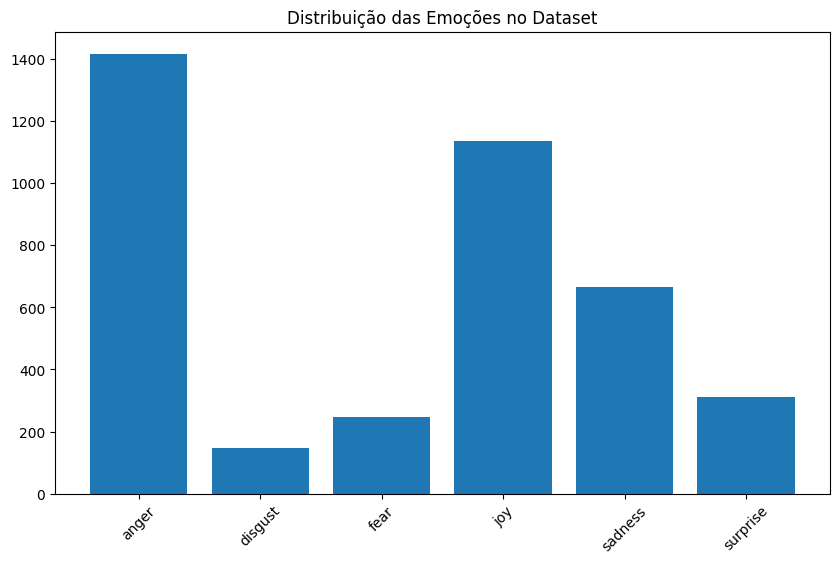

In [38]:
plt.figure(figsize=(10, 6))
emotion_counts = df[emotions].sum()
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Distribuição das Emoções no Dataset')
plt.xticks(rotation=45)
plt.show()

In [39]:
def analisar_classificacoes(y_pred):
    """
    Analisa as classificações de um modelo, contando 0s e 1s por emoção
    """
    for i, emotion in enumerate(emotions):
        zeros = (y_pred[:, i] == 0).sum()
        uns = (y_pred[:, i] == 1).sum()
        total = len(y_pred[:, i])
        
        # Calcula percentuais
        porc_zeros = (zeros / total) * 100
        porc_uns = (uns / total) * 100
        
        print(f"\n{emotion.upper()}:")
        print(f"  Classe 0 (ausente): {zeros} ({porc_zeros:.1f}%)")
        print(f"  Classe 1 (presente): {uns} ({porc_uns:.1f}%)")
        print(f"  Total: {total}")


In [40]:
print("Regressão Logística\n")

analisar_classificacoes(y_predito_reg_log)

Regressão Logística


ANGER:
  Classe 0 (ausente): 887 (99.6%)
  Classe 1 (presente): 4 (0.4%)
  Total: 891

DISGUST:
  Classe 0 (ausente): 891 (100.0%)
  Classe 1 (presente): 0 (0.0%)
  Total: 891

FEAR:
  Classe 0 (ausente): 891 (100.0%)
  Classe 1 (presente): 0 (0.0%)
  Total: 891

JOY:
  Classe 0 (ausente): 839 (94.2%)
  Classe 1 (presente): 52 (5.8%)
  Total: 891

SADNESS:
  Classe 0 (ausente): 887 (99.6%)
  Classe 1 (presente): 4 (0.4%)
  Total: 891

SURPRISE:
  Classe 0 (ausente): 891 (100.0%)
  Classe 1 (presente): 0 (0.0%)
  Total: 891


In [41]:
print("MLP")

analisar_classificacoes(y_predito_mlp)

MLP

ANGER:
  Classe 0 (ausente): 823 (92.4%)
  Classe 1 (presente): 68 (7.6%)
  Total: 891

DISGUST:
  Classe 0 (ausente): 890 (99.9%)
  Classe 1 (presente): 1 (0.1%)
  Total: 891

FEAR:
  Classe 0 (ausente): 891 (100.0%)
  Classe 1 (presente): 0 (0.0%)
  Total: 891

JOY:
  Classe 0 (ausente): 821 (92.1%)
  Classe 1 (presente): 70 (7.9%)
  Total: 891

SADNESS:
  Classe 0 (ausente): 882 (99.0%)
  Classe 1 (presente): 9 (1.0%)
  Total: 891

SURPRISE:
  Classe 0 (ausente): 891 (100.0%)
  Classe 1 (presente): 0 (0.0%)
  Total: 891
